# OD-3. Принятие решения по результатам A/Б-теста

## PROJECT. Расчёт статистической значимости 
### <font color='#00b43f'>Для понимания эффективности новой фичи нужно</font>  
1. Рассчитать, насколько различаются конверсия, средний чек и ARPU пользователей в группах А и Б (ID теста 127, период теста с 2019-08-05 по 2019-08-11 включительно)
2. Сформировать выводы


In [1]:
# Импорты нужных библиотек и функций
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime

In [2]:
ab_test_groups = pd.read_csv('ab_test_groups.csv')
ab_test_groups.head()

,user_id,grp,ab_test_id
0,1,B,132
1,2,A,132
2,3,B,132
3,4,A,132
4,5,B,132


In [3]:
ab_test_groups = ab_test_groups.loc[ab_test_groups.ab_test_id == 127]

In [4]:
payments = pd.read_csv('payments.csv')
payments.head()

,payment_id,user_id,price,created_at,tariff
0,1,77831,200.0,2019-08-05 00:00:54,month
1,2,84576,200.0,2019-08-05 00:01:05,month
2,3,40981,140.0,2019-08-05 00:03:47,month_30off
3,4,130565,140.0,2019-08-05 00:09:33,month_30off
4,5,34758,700.0,2019-08-05 00:12:16,year_30off


In [5]:
# Фильтруем данные по дате через приведение столбца created_at к строковому типу данных. Можно применять и другие подходы,
# но при таком формате данных такой способ самый простой
payments = payments.loc[(payments.created_at.astype(str) >= '2019-08-05')&
            (payments.created_at.astype(str) < '2019-08-12'), ['user_id', 'price']]
payments.head()

,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0


In [6]:
payments = payments.groupby('user_id', as_index = False).agg({'price':'sum'})

In [7]:
ab_data = ab_test_groups.merge(payments, on = 'user_id', how = 'left')
ab_data.head()

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN


In [8]:
ab_summary = ab_data.groupby('grp').agg({'user_id':'count', 'price':'count'}) #Агрегация данных
ab_summary.rename(columns={'user_id':'users_count', 'price':'buyers_count'}, inplace = True) #Переименовывание столбцов
ab_summary

,users_count,buyers_count
grp,,
A,76605,4279
B,76627,9427


In [9]:
ab_summary.loc[ab_summary.index == 'A', 'users_count'].sum()/ab_summary.users_count.sum()

0.4999282134280046

In [10]:
ab_summary['conversion'] = ab_summary.buyers_count/ab_summary.users_count
ab_summary

,users_count,buyers_count,conversion
grp,,,
A,76605,4279,0.055858
B,76627,9427,0.123025


In [11]:
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'mean'}).rename(columns = {'price':'avg_bill'}), 
                 left_index = True, right_index = True) # Сделали агрегацию и прикрепили её к ab_summary
ab_summary

,users_count,buyers_count,conversion,avg_bill
grp,,,,
A,76605,4279,0.055858,396.120589
B,76627,9427,0.123025,348.804498


In [12]:
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'sum'}).rename(columns = {'price':'revenue'}), 
                 left_index = True, right_index = True) # Сделали агрегацию и прикрепили её к ab_summary
ab_summary['ARPU'] = ab_summary.revenue/ab_summary.users_count
ab_summary['Доп. выручка'] = ab_summary.users_count*(ab_summary.ARPU - ab_summary.loc['A', 'ARPU'])
ab_summary

,users_count,buyers_count,conversion,avg_bill,revenue,ARPU,Доп. выручка
grp,,,,,,,
A,76605,4279,0.055858,396.120589,1695000.0,22.126493,0.000000e+00
B,76627,9427,0.123025,348.804498,3288180.0,42.911506,1.592693e+06


In [13]:
ztest(ab_data.loc[ab_data.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0),# Конверсии пользователей группы А
     ab_data.loc[ab_data.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0) # Конверсии пользователей группы B
     ) 

(-46.38627328408593, 0.0)

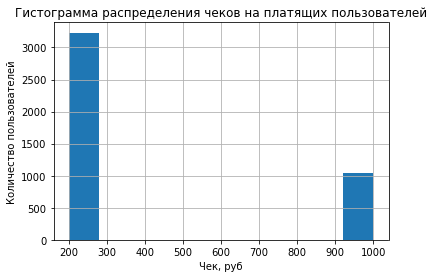

Shapiro-Wilk p-value is 0.0


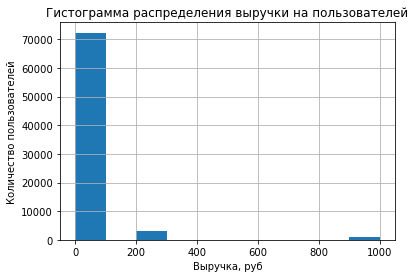

Shapiro-Wilk p-value is 0.0


D:\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [14]:
ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].dropna())[1])

ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0))[1])

In [15]:
print(stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna()),
stats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna())
      , sep = '\n')

MannwhitneyuResult(statistic=11353450.0, pvalue=0.0)
Ttest_indResult(statistic=8.681488291725874, pvalue=4.342920451712972e-18)


In [16]:
# Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):  
# Считает доверительные интервалы для средних
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
# Считает доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [17]:
get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)) 
# Доверительный полуинтервал для АРПУ пользователей в группе А

0.8641428736438357

In [18]:
# Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {'ARPU':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'A', 'user_id'].count()),
                               'B':get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'B', 'user_id'].count())},
                  'avg_bill':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna()),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna())}
                 }

In [19]:
# Удобная функция для подстановки подписей на barplot
def set_labels(axes):  
# Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()  
# размер графика по оси Y
    y_shift = 0.15* (y1 - y0)  
# дополнительное место под надписи

    for i, rect in enumerate(axes.patches):  
# по всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  
# посередине прямоугольника
        y = height + y_shift * 0.8  
# над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [20]:
plot_summary = ab_summary.T 
# Транспонированная таблица для удобства использования
significant_changes = ['conversion', 'avg_bill'] 
# Метрики со статзначимыми различиями

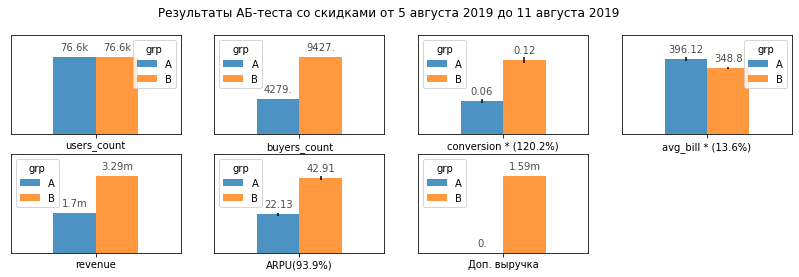

In [21]:
from matplotlib import gridspec
from math import ceil

ax = [] 
# Массив для складирования графиков
n_pict_in_line = 4 
# Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line) 
# Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row and "Доп. выручка" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста со скидками от 5 августа 2019 до 11 августа 2019')

## Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line])) 
# Добавляем subplot в нужную клетку
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8, 
# Строим график в нужной клетке
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
    
# Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

## Выводы:

* ARPU значимо вырос на 93,9 %
* Конверсия значимо увеличилась на 120 %
* Средний чек значимо упал на 13,6 %
* Доп.выручка в группе В составила 1,59 млн.руб.

Скидки способствуют мгновенному увеличению выручки, имеет смысл проводить время от времени